# Comparing GNINA against real data

/home/mrr/miniconda3/envs/chodera/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


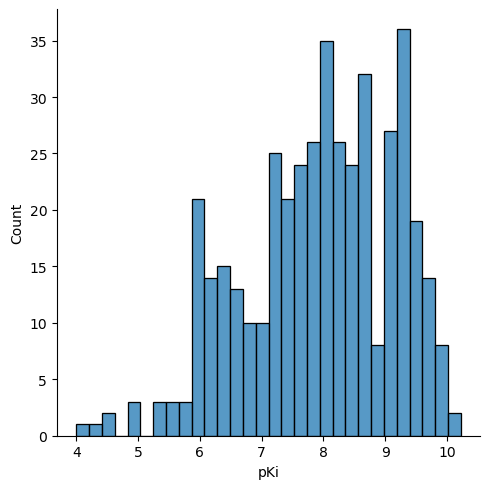

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns

# df = pd.read_csv('../../dgym-data/chembl_test_igf1r.tsv', sep='\t')
# df = df.dropna(subset=['pChEMBL Value'])
# sample = df.sample(200)

df = pd.read_csv('../../dgym-data/bindingDB_ADAM17.tsv', sep='\t')
df = df.dropna(subset=['Ki (nM)'])
df['Ki (nM)'] = df['Ki (nM)'].str.replace('>', '')
df['Ki (nM)'] = df['Ki (nM)'].astype(float)
df['Ki (M)'] = df['Ki (nM)'] * 1e-9
df['pKi'] = -np.log10(df['Ki (M)'])

sns.displot(df['pKi'], bins=30)

Dock molecules.

In [4]:
%reload_ext autoreload
%autoreload 2

import rdkit
rdkit.Chem.Draw.IPythonConsole.ipython_maxProperties = -1

import dgym as dg

In [5]:
import os

path = '../../dgym-data/'

dockstring_dir = f'{path}/dockstring_targets/'
files = os.listdir(dockstring_dir)
configs = sorted([f for f in files if 'conf' in f])
targets = sorted([f for f in files if 'target' in f])

idx = 2 # 30 for IGF1R
with open(dockstring_dir + configs[idx], 'r') as f:
    config_ = f.readlines()
    config_ = [c.replace('\n', '') for c in config_]
    config_ = [c.split(' = ') for c in config_ if c]
    config_ = {c[0]: float(c[1]) for c in config_}

target = targets[idx]
name = target.split('_')[0]

config_.update({
    'size_x': 15,
    'size_y': 15,
    'size_z': 15,
})

from dgym.envs.oracle import DockingOracle, NeuralOracle, NoisyOracle
from dgym.envs.utility import ClassicUtilityFunction

config = {
    'search_mode': 'balanced',
    'scoring': 'vinardo',
    'seed': 5,
    **config_
}

# Create noiseless evaluators
docking_oracle = DockingOracle(
    f'{name} affinity',
    receptor_path=f'{dockstring_dir}/{target}',
    config=config
)

In [6]:
deck = dg.collection.Collection([
    dg.molecule.Molecule(molecule) for molecule in df['Ligand SMILES']
])

In [15]:
import math
import numpy as np

def convert_vina_scores_to_pKi(delta_G, T=298.15):
    """
    Convert docking scores from kcal/mol to pKi values.
    
    Parameters
    ----------
    delta_G : float or np.array
        The docking score in kcal/mol from AutoDock Vina.
    T : float, optional
        The temperature in Kelvin. Default is 298.15 K, which is
        typical for biological systems.
    
    Returns
    -------
    pKi : float or np.array
        The pKi value, which is the negative log of the inhibition
        constant in molar units.
    """
    R = 1.9872036e-3  # kcal/mol/K, universal gas constant
    pKi = -delta_G / (R * T * np.log(10))
    return pKi

scores = docking_oracle(deck)
deltaG = [s / (-math.log10(math.e) / 0.6) for s in scores]
pKi_pred = convert_vina_scores_to_pKi(np.array(deltaG))

Text(0.5, 1.0, 'Actual pKi vs. predicted pKi | ADAM17 | AutodockVina + VINARDO')

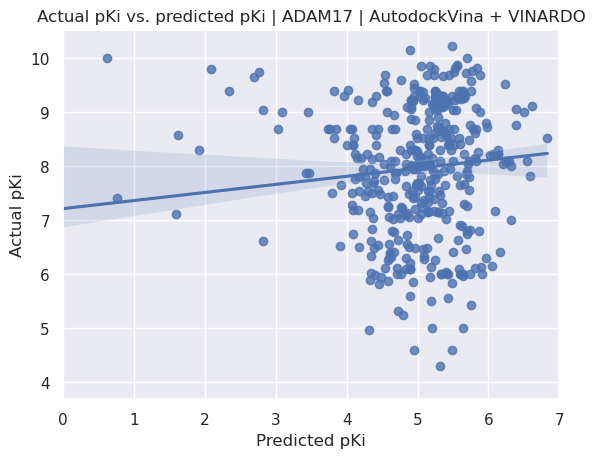

In [35]:
import matplotlib.pyplot as plt
sns.set()
g = sns.regplot(
    x=[p[1] for p in enumerate(pKi_pred) if p[0] != 407],
    y=[p[1] for p in enumerate(df['pKi']) if p[0] != 407],
    robust=True
)

plt.xlabel('Predicted pKi')
plt.ylabel('Actual pKi')
plt.xlim(0.0, 7)

plt.title('Actual pKi vs. predicted pKi | ADAM17 | AutodockVina + VINARDO')

In [34]:
from scipy.stats import pearsonr

# pearsonr(
#     scores, df['pKi'].tolist()
# )

score_pairs = np.array([
    l
    for l in list(zip(pKi_pred, df['pKi'].tolist()))
    if l[0] != float('-inf') and not np.isnan(l[0])
]).T

pearsonr(score_pairs[0], score_pairs[1])

PearsonRResult(statistic=0.12383170605684468, pvalue=0.012093266984158555)

In [266]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()

In [267]:
model.fit(score_pairs[0].reshape(-1, 1), score_pairs[1])

LinearRegression()

In [268]:
model.coef_

array([0.35679019])